# Dublinbikes Project
<img src="https://www.dublinbikes.ie/assets/img/home/accueil-une-bg.jpg" alt="A row of Dublin Bikes in front of Dublin's Custom House" width="800"/>

This project is undertaken for the [Programming for Data Analytics](https://www.atu.ie/courses/higher-diploma-in-science-data-analytics#:~:text=Programming%20for%20Data%20Analytics) module as part of the [Higher Diploma in Science in Data Analytics](https://www.atu.ie/courses/higher-diploma-in-science-data-analytics) at ATU.

The brief for this project was quite broad:

> Write a notebook that demonstrates what you have learned in the Module, if you can not think of an area you wish to explore, then create a project that analyses windspeed for windfarms.

As I have an interest is public transport, library-type sharing systems, and the movement towards better utilisation of public service data, I have decided to interrogate some of the freely available data for the [Dublinbikes](https://www.dublinbikes.ie/) bike-sharing scheme.

In [116]:
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for visualisations
import folium as fl # for mapping
from datetime import datetime # for datetime functions
import matplotlib.dates as mdates # for plotting dates
from matplotlib.ticker import MaxNLocator # for tick placement formatting
from matplotlib.animation import PillowWriter, FuncAnimation # for creating GIFs

# set Seaborn visual theme for plots
sns.set()

## Overview

In [117]:
# reading the CSV into a dataframe and getting a quick overview
df = pd.read_csv("https://data.smartdublin.ie/dataset/33ec9fe2-4957-4e9a-ab55-c5e917c7a9ab/resource/6bad1ee7-2c2b-4a52-9567-db7445fc64ff/download/dublinbike-historical-data-2024-01.csv")
df.head()

,STATION ID,TIME,LAST UPDATED,NAME,BIKE_STANDS,AVAILABLE_BIKE_STANDS,AVAILABLE_BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE
0,1,2024-01-01 00:00:02,2023-12-31 23:59:40,CLARENDON ROW,31,8,23,OPEN,Clarendon Row,53.3409,-6.26250
1,2,2024-01-01 00:00:02,2023-12-31 23:57:55,BLESSINGTON STREET,20,18,2,OPEN,Blessington Street,53.3568,-6.26814
2,3,2024-01-01 00:00:02,2023-12-31 23:59:33,BOLTON STREET,20,18,2,OPEN,Bolton Street,53.3512,-6.26986
3,4,2024-01-01 00:00:02,2023-12-31 23:49:57,GREEK STREET,20,10,10,OPEN,Greek Street,53.3469,-6.27298
4,5,2024-01-01 00:00:02,2023-12-31 23:51:04,CHARLEMONT PLACE,40,8,32,OPEN,Charlemont Street,53.3307,-6.26018


In [118]:
# change station names to title case
df['NAME'] = df['NAME'].str.title()
# get dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169062 entries, 0 to 169061
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   STATION ID             169062 non-null  int64  
 1   TIME                   169062 non-null  object 
 2   LAST UPDATED           169062 non-null  object 
 3   NAME                   169062 non-null  object 
 4   BIKE_STANDS            169062 non-null  int64  
 5   AVAILABLE_BIKE_STANDS  169062 non-null  int64  
 6   AVAILABLE_BIKES        169062 non-null  int64  
 7   STATUS                 169062 non-null  object 
 8   ADDRESS                169062 non-null  object 
 9   LATITUDE               169062 non-null  float64
 10  LONGITUDE              169062 non-null  float64
dtypes: float64(2), int64(4), object(5)
memory usage: 14.2+ MB


The data contains 11 columns:
1. **STATION ID**: a unique identifying digit for each Dublinbike station
2. **TIME**: a timestamp for the data
3. **LAST UPDATED**: when the data was last updated
4. **NAME**: the station name
5. **BIKE_STANDS**: the total number of bike stands at the station
6. **AVAILABLE_BIKE_STANDS**: the number of stands available to deposit a bike
7. **AVAILABLE_BIKES**: the number of bikes available to borrow
8. **STATUS**: the open/closed status of the station
9. **ADDRESS**: the address at which the station is located
10. **LATITUDE**: the co-ordinates of the station's latitude
11. **LONGITUDE**: the co-ordinates of the station's longitude

I can see from the <code>info()</code> overview that there are no null values in the dataset. This will make analysing the data more straightforward. I won't always be this lucky - if I come across null values in another analysis I will need to determine a suitable approach for handling them depending on the nature of the overall dataset - would I remove them entirely; or average them out depending on the values either side of them? Null values need to be considered in their context on each instance.

In [119]:
# TIME column is currently an object, so convert to datetime in the specified format
df['TIME'] = pd.to_datetime(df['TIME'], format="%Y-%m-%d %H:%M:%S")
# confirm new datatype
df['TIME'].dtype

dtype('<M8[ns]')

## Mapping
### Location-Based Analysis
Next up, I'd like to take a look at the geographical distribution of bike stands across the city. Since I have Latitude and Longitude info for each station, I will create a dataframe for each unique instance.

In [120]:
# extract unique detail to own dataframe
# sort bike stands by ascending
unique_df = df[['NAME', 'BIKE_STANDS','LATITUDE', 'LONGITUDE']].drop_duplicates()
unique_df = unique_df.sort_values(by='BIKE_STANDS', ascending=True)

# display the resulting dataframe
unique_df.head()

,NAME,BIKE_STANDS,LATITUDE,LONGITUDE
9,Dame Street,16,53.3440,-6.26680
14,Hardwicke Street,16,53.3555,-6.26442
23,Cathal Brugha Street,20,53.3521,-6.26053
57,Denmark Street Great,20,53.3556,-6.26140
15,Georges Quay,20,53.3475,-6.25219


Now I'll take a look at the number of bike stands at each unique location.

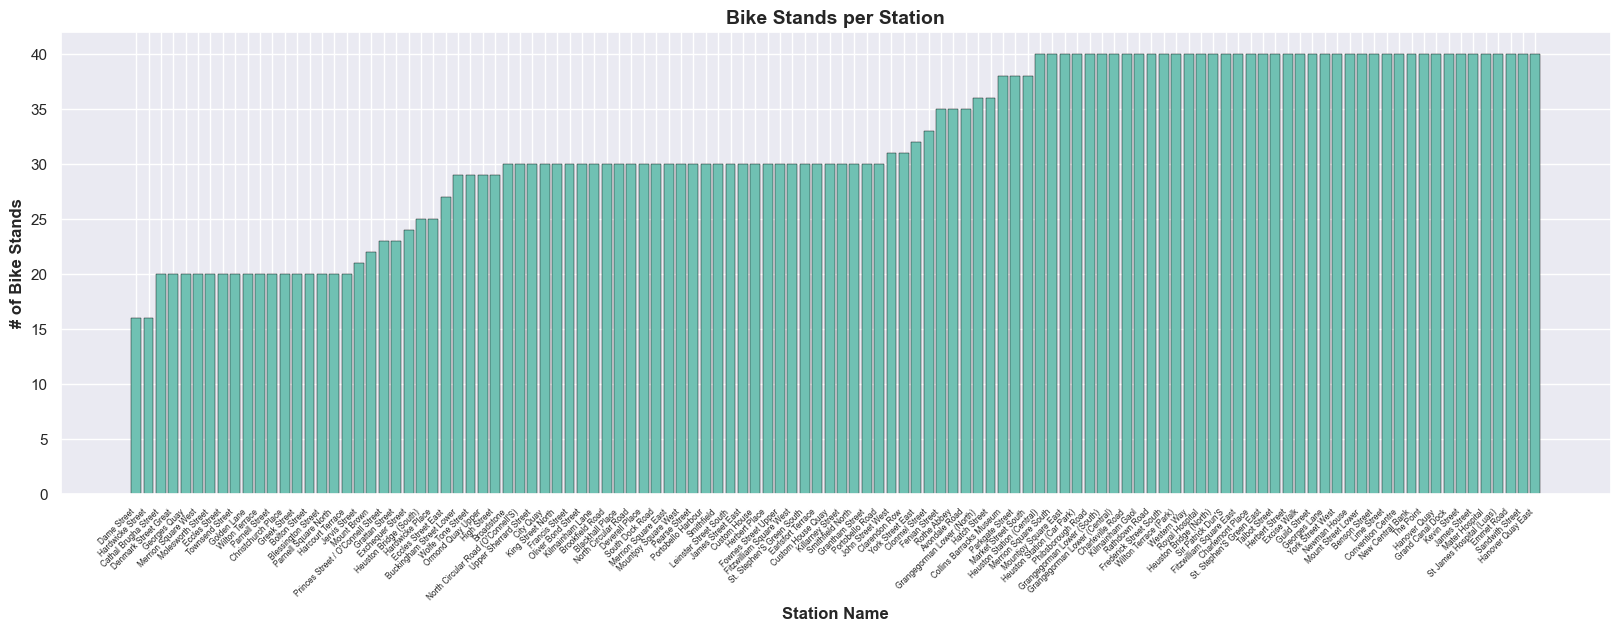

In [121]:
# show distribution of bike stands across the various stations
plt.figure(figsize=(20, 6))
plt.bar(unique_df['NAME'], unique_df['BIKE_STANDS'], color='#70C1B3', edgecolor='black', linewidth=0.3)
plt.xlabel('Station Name', fontsize=12, weight='bold')
plt.ylabel('# of Bike Stands', fontsize=12, weight='bold')
plt.title('Bike Stands per Station', fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=6)

plt.show()

Bike stands seem to have three main tiers - 20/30/40 stands. I'll assign a size categorisation to each station with 0-20 as Small, 21-30 as Medium, and 31-40 as Large.

In [122]:
# split stations into Small/Medium/Large groupings based on the breakout above
unique_df['SIZE'] = pd.cut(
    unique_df['BIKE_STANDS'],
    bins=[0, 20, 30, 40],
    labels=['Small', 'Medium', 'Large'],
    right=True  # includes the rightmost edge in each bin
)

unique_df.head()

,NAME,BIKE_STANDS,LATITUDE,LONGITUDE,SIZE
9,Dame Street,16,53.3440,-6.26680,Small
14,Hardwicke Street,16,53.3555,-6.26442,Small
23,Cathal Brugha Street,20,53.3521,-6.26053,Small
57,Denmark Street Great,20,53.3556,-6.26140,Small
15,Georges Quay,20,53.3475,-6.25219,Small


Now I'll map this data, and colour-code the map pins according to each station's size value.

In [123]:
# create base map centered on mean of co-ords
map_centre = [unique_df['LATITUDE'].mean(), unique_df['LONGITUDE'].mean()]
map = fl.Map(location=map_centre, zoom_start=14)

# define colour mapping for sizes
size_to_colour = {
    'Small': 'red',
    'Medium': 'orange',
    'Large': 'green'
}

# add pin for each location
for _, row in unique_df.iterrows():
    size = row['SIZE']
    color = size_to_colour.get(size, 'gray')  # default gray if size not in mapping
    # create markers
    fl.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=f"{row['NAME']}",
        icon=fl.Icon(color=color)
    ).add_to(map)

map.save('map.html')
map

## Availability
### Time-Based Analysis
Having looked at the Dublinbikes data on the basis of geographic location, now I'll take a look at some time-based analysis.

First I will set the <code>TIME</code> column as the Index: this will allow for resampling easily. I'm also going to create a column that indicates the percentage of available bikes at any given time by showing available bikes as a proportion of overall bike stands.

In [124]:
# set TIME column as dataframe index to allow for resampling and other time-based operations
df.set_index('TIME', inplace=True)

# add a column showing the percentage of bikes available at any given time
df['PERCENT_AVAILABLE'] = df['AVAILABLE_BIKES'] / df['BIKE_STANDS']
df.head()

,STATION ID,LAST UPDATED,NAME,BIKE_STANDS,AVAILABLE_BIKE_STANDS,AVAILABLE_BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,PERCENT_AVAILABLE
TIME,,,,,,,,,,,
2024-01-01 00:00:02,1,2023-12-31 23:59:40,Clarendon Row,31,8,23,OPEN,Clarendon Row,53.3409,-6.26250,0.741935
2024-01-01 00:00:02,2,2023-12-31 23:57:55,Blessington Street,20,18,2,OPEN,Blessington Street,53.3568,-6.26814,0.100000
2024-01-01 00:00:02,3,2023-12-31 23:59:33,Bolton Street,20,18,2,OPEN,Bolton Street,53.3512,-6.26986,0.100000
2024-01-01 00:00:02,4,2023-12-31 23:49:57,Greek Street,20,10,10,OPEN,Greek Street,53.3469,-6.27298,0.500000
2024-01-01 00:00:02,5,2023-12-31 23:51:04,Charlemont Place,40,8,32,OPEN,Charlemont Street,53.3307,-6.26018,0.800000


Now I'm going to take a look at one specific station, and see how the bike availability changes over time, taking a look bikes available by hour over the course of the month. For now I'm looking at absolute numbers of bikes available, rather than the percentage value.

**The Point** is one of the largest stations, with 40 total bike stands, so I'll look at that for now.

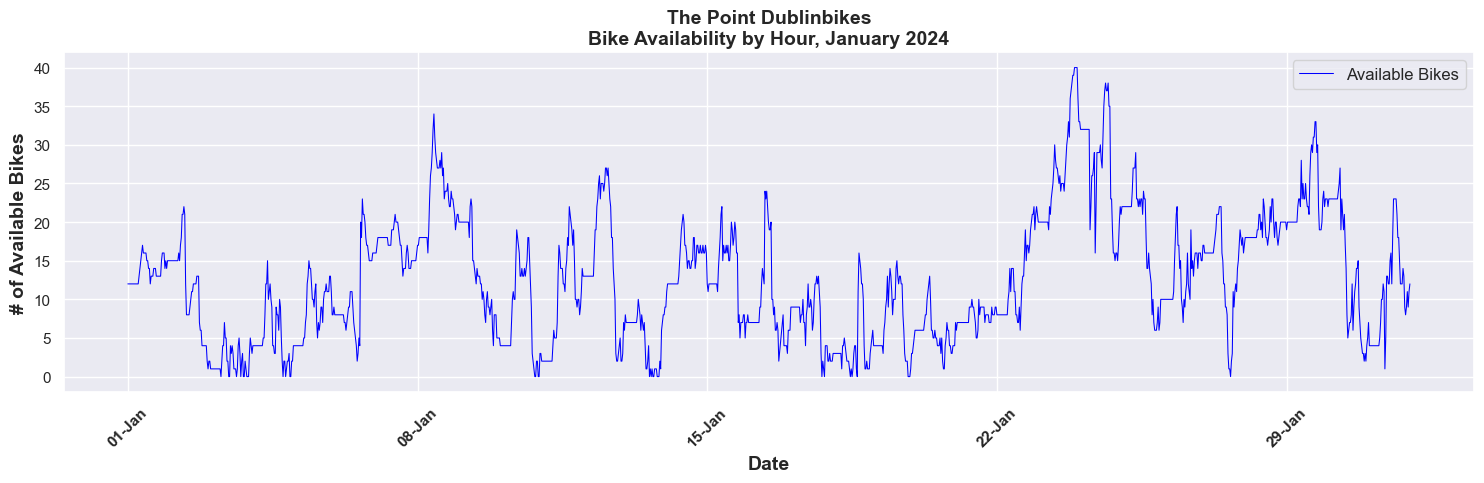

In [125]:
# create dataframe filtering by station
point_df = df[df['NAME'] == 'The Point']
time = point_df.index # index column is timestamp
bikes = point_df['AVAILABLE_BIKES']

# plot the data
plt.figure(figsize=(15, 5))
plt.plot(time, bikes, label='Available Bikes', color='blue', linewidth=0.75)

# customise the plot
plt.title('The Point Dublinbikes\nBike Availability by Hour, January 2024', fontsize=14, weight='bold')
plt.xlabel('Date', fontsize=14, weight='bold')
plt.ylabel('# of Available Bikes', fontsize=14, weight='bold')
plt.legend(fontsize=12, loc=1)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

plt.xticks(rotation=45, weight='bold')

# show the plot
plt.tight_layout()
plt.show()

**The Point** has a variety of peaks and troughs over the course of the month, but I'm aware this is an station on the edge of the city.

Next, I'll focus on a station that will have high commuter demand - **Heuston Bridge (South)**.

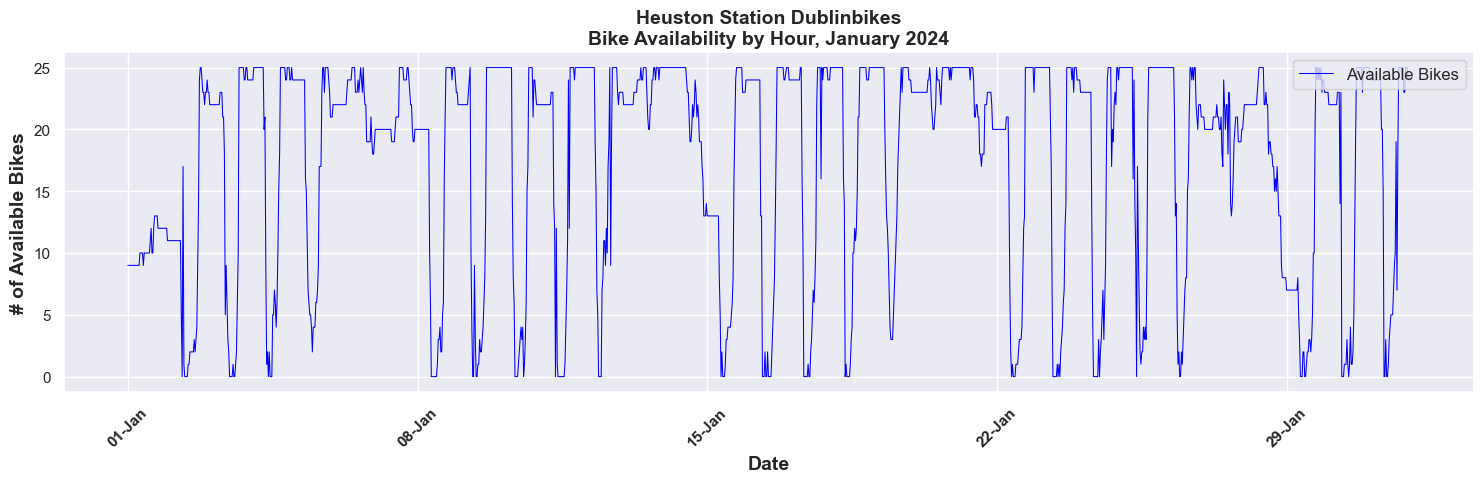

In [126]:
# create dataframe filtering by station
heuston_df = df[df['NAME'] == 'Heuston Bridge (South)']
time = heuston_df.index # index column is timestamp
bikes = heuston_df['AVAILABLE_BIKES']

# plot the data
plt.figure(figsize=(15, 5))
plt.plot(time, bikes, label='Available Bikes', color='blue', linewidth=0.75)

# customize the plot
plt.title('Heuston Station Dublinbikes\nBike Availability by Hour, January 2024', fontsize=14, weight='bold')
plt.xlabel('Date', fontsize=14, weight='bold')
plt.ylabel('# of Available Bikes', fontsize=14, weight='bold')
plt.legend(fontsize=12, loc=1)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

plt.xticks(rotation=45, weight='bold')

# show the plot
plt.tight_layout()
plt.show()

This definitely shows a distinct commuter pattern, with bike availabilty plummeting as commuters arrive to Heuston Station in the morning, and rising again towards the evening as bikes are returned by people heading for the evening train.

Now I'm going to look at the average bikes available by hour of day to take a further look at this pattern.

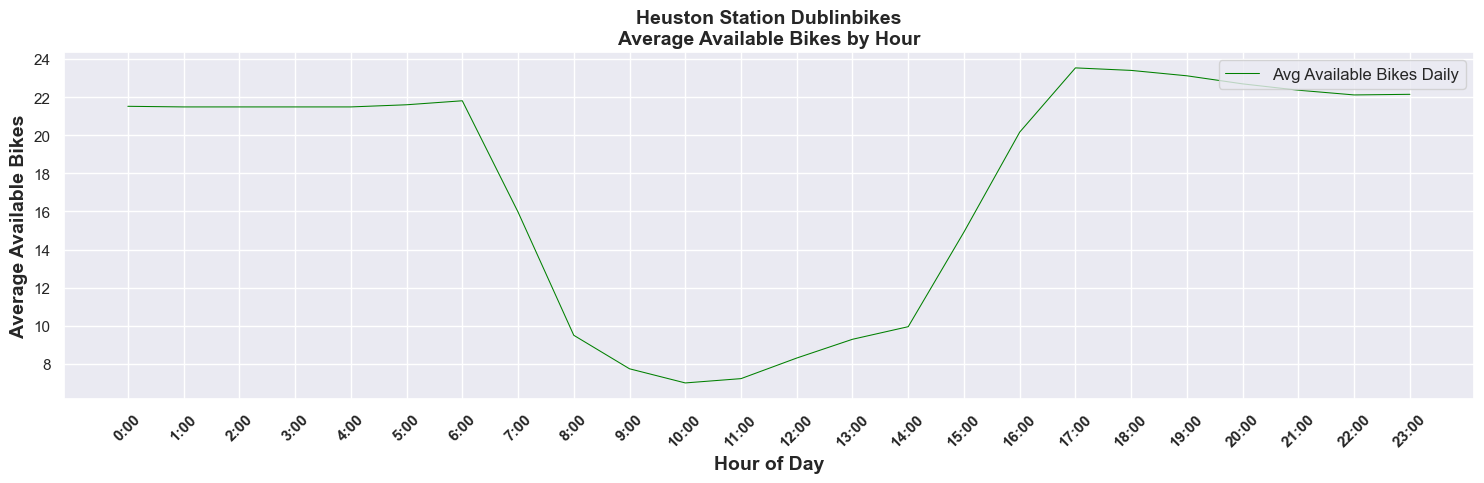

In [127]:
# group by hour and calc avg AVAILABLE_BIKES for each hour
heuston_avg_hourly_bikes = heuston_df.groupby(heuston_df.index.hour)['AVAILABLE_BIKES'].mean()

# plot the data
plt.figure(figsize=(15, 5))
plt.plot(heuston_avg_hourly_bikes.index, heuston_avg_hourly_bikes, label='Avg Available Bikes Daily', color='green', linewidth=0.75)

# customise the plot
plt.title('Heuston Station Dublinbikes\nAverage Available Bikes by Hour', fontsize=14, weight='bold')
plt.xlabel('Hour of Day', fontsize=14, weight='bold')
plt.ylabel('Average Available Bikes', fontsize=14, weight='bold')
plt.legend(fontsize=12, loc=1)

# customise x-axis to display hour labels
plt.xticks(heuston_avg_hourly_bikes.index, [f'{hour}:00' for hour in heuston_avg_hourly_bikes.index], rotation=45, weight='bold')

# customise y-axis to display integers
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# show the plot
plt.tight_layout()
plt.show()

The commuter pattern is clearer here as we the number of available bikes dropping gradually between 6am and 8am, and rising gradually between 2pm and 5pm: remaining broadly static overnight.

But commuting is a weekday phenomenon: let's see how it varies when compared to weekends.

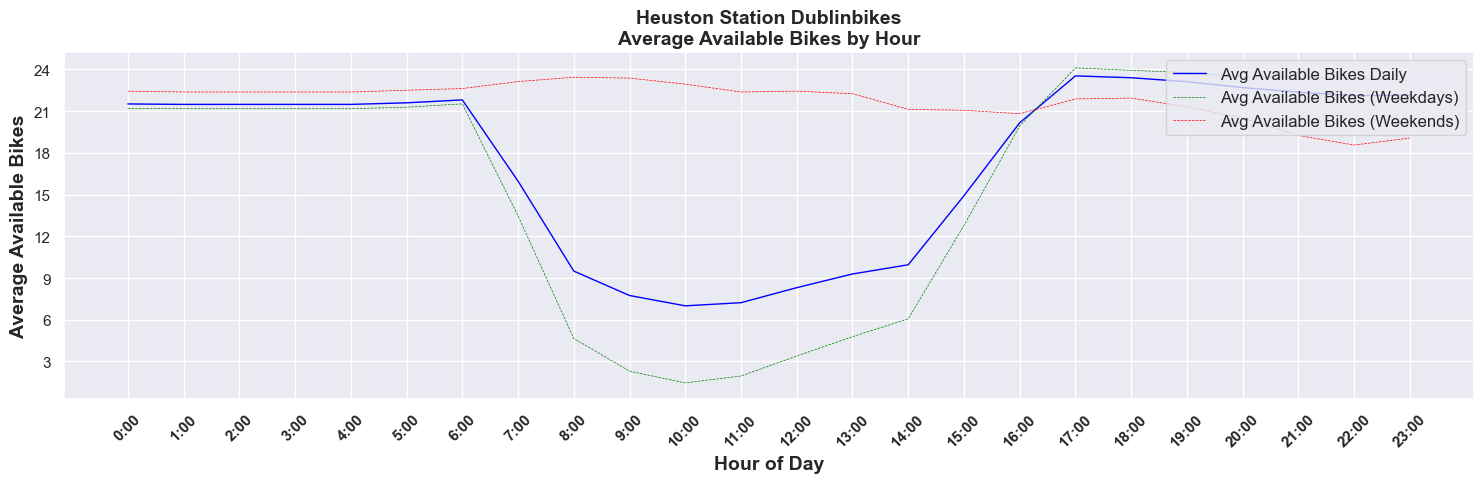

In [128]:
# filter dataframe to include only weekdays
heuston_weekdays_df = heuston_df[heuston_df.index.weekday.isin([0, 1, 2, 3, 4])] # Mon to Fri

# group by hour and calculate avg AVAILABLE_BIKES for weekdays
heuston_avg_hourly_bikes_weekdays = heuston_weekdays_df.groupby(heuston_weekdays_df.index.hour)['AVAILABLE_BIKES'].mean()

# filter dataframe to include only weekends
heuston_weekends_df = heuston_df[heuston_df.index.weekday.isin([5, 6])] # Sat and Sun

# group by hour and calculate avg AVAILABLE_BIKES for weekends
heuston_avg_hourly_bikes_weekends = heuston_weekends_df.groupby(heuston_weekends_df.index.hour)['AVAILABLE_BIKES'].mean()

# plot overall avg for available bikes
plt.figure(figsize=(15, 5))
plt.plot(heuston_avg_hourly_bikes.index, heuston_avg_hourly_bikes, label='Avg Available Bikes Daily', color='blue', linewidth=1)

# plot weekday avg as dotted line
plt.plot(heuston_avg_hourly_bikes_weekdays.index, heuston_avg_hourly_bikes_weekdays, label='Avg Available Bikes (Weekdays)', color='green', linestyle='--', linewidth=0.5)

# plot weekend avg as dotted line
plt.plot(heuston_avg_hourly_bikes_weekends.index, heuston_avg_hourly_bikes_weekends, label='Avg Available Bikes (Weekends)', color='red', linestyle='--', linewidth=0.5)

# customise the plot
plt.title('Heuston Station Dublinbikes\nAverage Available Bikes by Hour', fontsize=14, weight='bold')
plt.xlabel('Hour of Day', fontsize=14, weight='bold')
plt.ylabel('Average Available Bikes', fontsize=14, weight='bold')
plt.legend(fontsize=12, loc=1)

# customise x-axis to display hour labels
plt.xticks(heuston_avg_hourly_bikes.index, [f'{hour}:00' for hour in heuston_avg_hourly_bikes.index], rotation=45, weight='bold')

# customise y-axis to display integers
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# show the plot
plt.tight_layout()
plt.show()


The pattern is even more pronounced when we separate out weekdays from weekends: weekends are practically steady over the course of the day, while the pattern is really being defined heavily by the weekday bike usage.

Now I'd like to create a GIF that utilises the percentage column created earlier to show the percentage of available bikes over the course of the day.

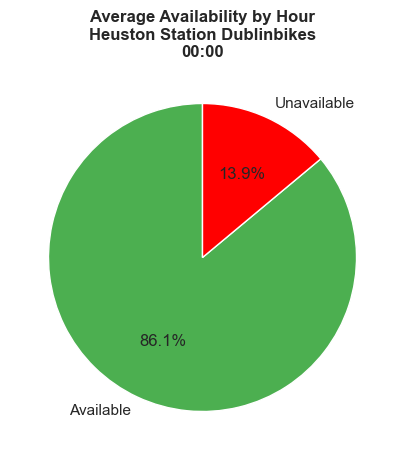

In [129]:
# assign an hour value to each row of data
heuston_df = heuston_df.assign(Hour=heuston_df.index.hour)

# calc avg percentage available for each hour of the day
hourly_avg = heuston_df.groupby('Hour')['PERCENT_AVAILABLE'].mean()

# function to create pie chart for specific hour
def create_pie_chart(hour, ax):
    percent_available = hourly_avg.loc[hour]
    data = [percent_available, 1 - percent_available]
    labels = ['Available', 'Unavailable']
    colors = ['#4CAF50', '#FF0000']  # green for available, red for unavailable
    
    ax.clear()
    ax.pie(data, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title(f'Average Availability by Hour\nHeuston Station Dublinbikes\n{hour:02d}:00', weight='bold', fontsize=12)

# create GIF
fig, ax = plt.subplots(figsize=(5, 5))

# animation function
def update(hour):
    create_pie_chart(hour, ax)

# configure animation
ani = FuncAnimation(fig, update, frames=range(24), repeat=True)

# save output as a GIF
output_file = 'heuston_hourly_availability.gif'
ani.save(output_file, writer=PillowWriter(fps=1))

<img src="https://raw.githubusercontent.com/JBnkn/4369-programming-for-data-analytics/refs/heads/main/Project/heuston_hourly_availability.gif" width="500" align="center">